DAY 10 - Mar 6, 2017

Yesterday I alluded to some features being more informative than others. Today I want to look at feature selection. We will again use the [Digit Recognizer](https://www.kaggle.com/c/digit-recognizer/data) Kaggle MNIST data set.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier

import os
import math
from scipy import mean

In [2]:
%matplotlib inline

plt.rcParams["figure.figsize"] = [15,6]

In [3]:
# Load Data
input_dir = "./data/"

# Load my data
train_file = os.path.join(input_dir, "train.csv")
test_file = os.path.join(input_dir, "test.csv")

train = pd.read_csv(train_file)
test = pd.read_csv(test_file)


# The features
features = train.columns[1:]
n_features = len(features)
n_outputs = len(set(train["label"]))

# Create different data sets i.e. for training & validating
dim = train.shape
train_num = int(dim[0] * 0.8)
val_num = dim[0] - train_num

X_train, y_train = train.iloc[:train_num,1:], train.iloc[:train_num,0]
X_val, y_val = train.iloc[train_num:,1:], train.iloc[train_num:,0]


print("feature:", n_features)
print("outputs:", n_outputs)
print("train:", train_num)
print("valid:", val_num)

feature: 784
outputs: 10
train: 33600
valid: 8400


In [4]:
def train_nn(X_train, X_val, n_neurons = 397):
    clf = MLPClassifier(alpha=1e-5,
                        hidden_layer_sizes=(n_neurons,),
                        random_state=1)
    clf.fit(X_train, y_train)
    
    print(sum(clf.predict(X_val) == y_val) / len(y_val))
    
    return(clf)

In [5]:
def draw_feature_heatmap(clf):
    a = clf.coefs_[0]
    a = np.matrix.transpose(a)
    
    print("Coefs range: ({:.2f}, {:.2f})".format(a.min(), a.max()))
    return(plt.imshow(a, cmap=plt.cm.seismic, alpha=1))

In [6]:
clf = {}
clf["default"] = train_nn(X_train, X_val)

0.965476190476


Coefs range: (-0.20, 0.17)


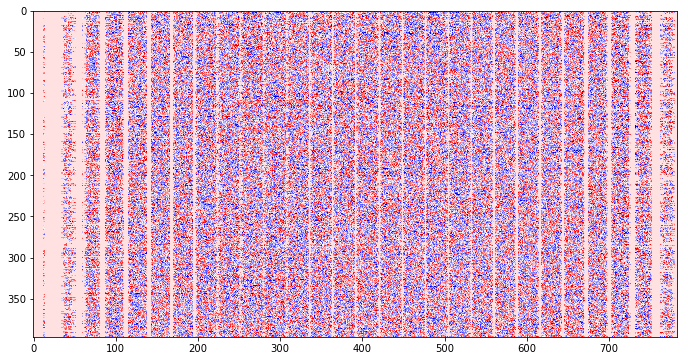

In [7]:
draw_feature_heatmap(clf["default"])

### Feature selection

Feature selection is the subsetting of relevant features (e.g. variables, predictors) for use in model construction. According to [Jason Brownlee (2014)](http://machinelearningmastery.com/feature-selection-in-python-with-scikit-learn/), feature selection "reduces overfitting, improves accuracy, and reduces training time". 

http://scikit-learn.org/stable/modules/feature_selection.html

### Removing features with low variance
Removes all features whose variance doesn't meet some threshold (arbitrarily threshold=0.1).

In [8]:
from sklearn.feature_selection import VarianceThreshold

In [9]:
sel = VarianceThreshold(threshold=0.1)

# Fit & Take note of how many features
n_features = sel.fit_transform(X_train).shape[1]
n_neurons = int(mean([n_features, n_outputs]))

print("Features:", n_features)
print("Neurons:", n_neurons)

Features: 689
Neurons: 349


In [10]:
clf["rm_low_var"] = train_nn(X_train = sel.transform(X_train),
                             X_val = sel.transform(X_val),
                             n_neurons = n_neurons)

0.96630952381


Slightly better

Coefs range: (-0.21, 0.24)


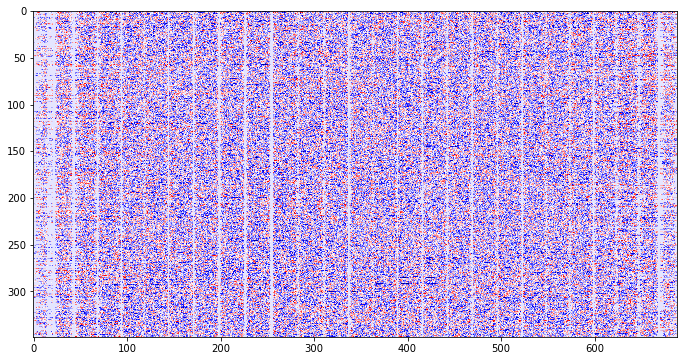

In [11]:
draw_feature_heatmap(clf["rm_low_var"])

### Univariate feature selection

Removes all but the highest scoring features. In Sci-kit learn, you could use `SelectKBest()` or `SelectPercentile()`

In [12]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import chi2

In [13]:
sel2 = SelectPercentile(chi2, percentile=90)

# Fit & Take note of how many features
n_features = sel2.fit_transform(X_train, y_train).shape[1]
n_neurons = int(mean([n_features, n_outputs]))

print("Features:", n_features)
print("Neurons:", n_neurons)

Features: 705
Neurons: 357


0.963333333333
Coefs range: (-0.27, 0.20)


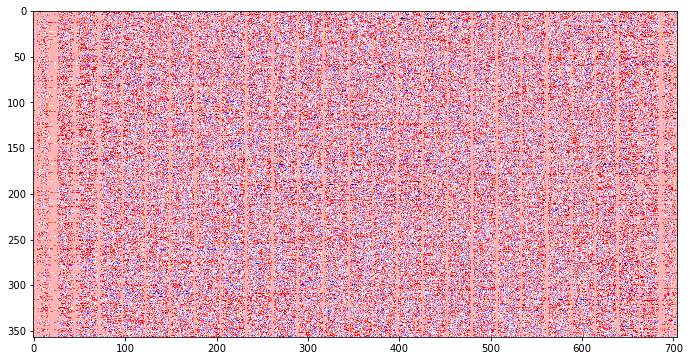

In [14]:
clf["univariate"] = train_nn(X_train = sel2.transform(X_train),
                             X_val = sel2.transform(X_val),
                             n_neurons = n_neurons)

draw_feature_heatmap(clf["univariate"])

Comparable but worst.

### Recursive Feature Elimination
Example from: http://machinelearningmastery.com/feature-selection-in-python-with-scikit-learn/

In [15]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

```
# create a base classifier used to evaluate a subset of attributes
model = LogisticRegression()

# create the RFE model and select 350 attributes
rfe = RFE(model, 350)
rfe.fit(X_train, y_train)

# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)
```

Super slow. Did not run.

### Feature Importance

Use the important features from one classifier.

In [9]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

In [10]:
# Fits a number of randomized decision trees
model = ExtraTreesClassifier(n_estimators = 30)
model.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [11]:
# Select the important features of previous model
sel3 = SelectFromModel(model, prefit=True)

# Take note of how many features
n_features = sel3.transform(X_train).shape[1]
n_neurons = int(mean([n_features, n_outputs]))

print("Features:", n_features)
print("Neurons:", n_neurons)

Features: 271
Neurons: 140


In [13]:
clf["feature_importance"] = train_nn(X_train = sel3.transform(X_train),
                                     X_val = sel3.transform(X_val),
                                     n_neurons = n_neurons)

#draw_feature_heatmap(clf["feature_importance"])

0.954880952381


NameError: name 'clf' is not defined

### Submit to Kaggle
by removing features with low variance

In [6]:
# Use all data
X = X_train.append(X_val)
y = y_train.append(y_val)

# Remove features with low variance
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=0.1)

# Fit & Take note of how many features
n_features = sel.fit_transform(X).shape[1]
n_neurons = int(mean([n_features, n_outputs]))

print("Features:", n_features)
print("Neurons:", n_neurons)

# Train clasifier
clf_all = MLPClassifier(alpha=1e-5,
                        hidden_layer_sizes=(n_neurons,),
                        random_state=1)
clf_all.fit(X, y)

Features: 688
Neurons: 349


MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(349,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

Coefs range: (-0.24, 0.19)


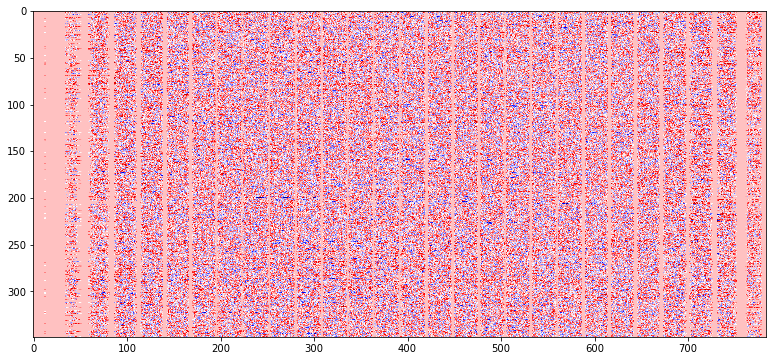

In [23]:
draw_feature_heatmap(clf_all)

In [20]:
# Predict
testall_yhat = clf_all.predict(test)

# Save results
pd.DataFrame({"ImageId":test.index+1, "Label":testall_yhat}).to_csv("digitrecognizer-nn-all-fs_submission.csv", index=False)
!head digitrecognizer-nn-all-fs_submission.csv

ImageId,Label
1,2
2,0
3,9
4,9
5,3
6,7
7,0
8,3
9,0


Kaggle: "Your submission scored 0.96343, which is not an improvement of your best score. Keep trying!"